# IMA 206 - Coding autoencoders in Pytorch

The lab was originally created by Alasdair Newson (https://sites.google.com/site/alasdairnewson/)

The current version is made by Loic Le Folgoc. If you have questions, please contact me at loic dot lefolgoc at telecom-paris dot fr.

## Objective:

The goal of this TP is to explore autoencoders and variational autoencoders applied to a simple dataset. In this first part, we will look at an autoencoder applied to MNIST. We recall that an autoencoder is a neural network with the following general architecture:


![AUTOENCODER](https://drive.google.com/uc?id=11dfNujSHa2-_eThp2aTpL1M_hLaEQX-G)


The tensor $z$ in the middle of the network is called a __latent code__, and it belongs to the latent space. It is this latent space which is interesting in autoencoders (for image synthesis, editing, etc).

## Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE or ...)

First of all, let's load some packages:

In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import pdb
import numpy as np
import matplotlib.pyplot as plt

In [72]:
from tqdm import tqdm

First, we load the mnist dataset. I find that training on the full training dataset `mnist_trainset` is fast enough even on CPU (5-10 minutes), but should you need it, we create a reduced trainset below.

Feel free to train on `mnist_trainset_reduced` instead if you prefer (results might be of poorer quality). To do so, replace the argument `mnist_trainset` in the `torch.utils.data.DataLoader(...)` call creating `mnist_train_loader` in the cell below by `mnist_trainset_reduced` (and same for `mnist_testset` and `mnist_testset_reduced`).

In [73]:
batch_size = 64

# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

#create data loader with smaller dataset size
max_mnist_size = 5000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0]
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, drop_last=False)

# download test dataset
max_mnist_size = 1000
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0]
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False, drop_last=False)


In [74]:
mnist_trainset.data.shape

torch.Size([60000, 28, 28])

# 1. Vanilla Autoencoder

Now, we define our autoencoder model. The autoencoder class `AEModel` is made of an `Encoder` and a `Decoder`, which we create first. We will reuse the `Encoder` and `Decoder` classes when building our variational autoencoder model, and wrap them in a `VAEModel` instead.

We will use the following convolutional architectures :

__Encoder__ :
- Conv layer, 32 filters, 4x4 kernel, stride=2, padding=1; + ReLU
- Conv layer, 32 filters, 4x4 kernel, stride=2, padding=0; + ReLU
- Conv layer, 32 filters, 4x4 kernel, stride=2, padding=0; + ReLU
- Flatten
- Dense layer with 64 output neurons; + ReLU
- Dense layer with `self.latent_dim*self.multiplier` output neurons.

For the autoencoder, `self.multiplier=1` as the encoder outputs a `self.latent_dim`-dimensional latent code. For the variational autoencoder, we will set `self.multiplier=2` as the encoder will output `self.latent_dim`-dimensional mean and log-variance parameters of the Gaussian distribution $q_\phi(z|x)$.

__Decoder__ (the decoder of the AE and VAE are the same, they always outputs an image/probability map, given a code $z$ as input):
- Dense layer with 64 output neurons; + ReLU
- Dense layer with ??? output neurons; + ReLU
- Reshape, to a `(C, H, W)` tensor with `C=32`, `H=???`, `W=???`.
- Conv transpose layer, 32 filters, 4x4 kernel, stride=2, padding=0; +ReLU
- Conv transpose layer, 32 filters, 4x4 kernel, stride=2, padding=0; +ReLU
- Conv transpose layer, 1 filter, 4x4 kernel, stride=2, padding=1; +Sigmoid

The number of output neurons of the second dense layer is exactly the number of input neurons in the first dense layer of the encoder (i.e., the number of values in the feature maps of the conv layer immediately before it).

For the reshape operations, use the ```A.view(dim_1,dim_2,...)``` function, where ```A``` is your tensor.

__Hint for computing the number of neurons that are not given to you__: This [great resource](https://madebyollin.github.io/convnet-calculator/) lets you compute the size of the output tensor following any convolution layer depending on the input tensor shape and conv parameters.

In [86]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_dim=10, multiplier=1):
        super(Encoder, self).__init__()

        self.latent_dim = latent_dim
        self.multiplier = multiplier
        self.reshape = (32, 2, 2)  # C x H x W after last conv layer

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=0)

        # Fully connected layers
        self.lin1 = nn.Linear(in_features=32*2*2, out_features=64)  # Flatten 32 * 2 * 2
        self.lin2 = nn.Linear(in_features=64, out_features=self.latent_dim * self.multiplier)

    def forward(self, x):
        batch_size = x.size(0)

        # Apply convolutional layers with ReLU
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Flatten the output of conv3
        x = x.view(batch_size, -1)  # Flatten into (B, 32*2*2)

        # Apply first dense layer with ReLU
        x = F.relu(self.lin1(x))

        # Final dense layer for latent code
        x = self.lin2(x)

        if self.multiplier == 1:
            return x.view(batch_size, self.latent_dim)  # Reshape if needed to match the output dimensions
        else:
            return x.view(batch_size, self.latent_dim, self.multiplier)  # Reshape for VAE



In [90]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Decoder, self).__init__()

        self.reshape = (32, 2, 2)  # Shape to start the transpose convolutions

        # Fully connected layers
        self.lin1 = nn.Linear(in_features=latent_dim, out_features=64)
        self.lin2 = nn.Linear(in_features=64, out_features=32*2*2)

        # Convolutional layers
        self.convT1 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=0)
        self.convT2 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=0)
        self.convT3 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        batch_size = z.size(0)

        # Fully connected layers with ReLu activations
        z = F.relu(self.lin1(z))
        z = F.relu(self.lin2(z))

        # Reshape
        z = z.view(batch_size, *self.reshape)  # Reshape into the form before the first transposed conv layer

        # Convolutional layers with ReLu activations
        z = F.relu(self.convT1(z))
        z = F.relu(self.convT2(z))

        # Final conv layer with sigmoid activation
        z = torch.sigmoid(self.convT3(z))

        return z


In [91]:
# Example usage
latent_dim = 10
decoder = Decoder(latent_dim)

# Create a dummy latent vector
dummy_latent_vector = torch.randn(batch_size, latent_dim)
output = decoder(dummy_latent_vector)
print(output.shape)

torch.Size([64, 1, 28, 28])


The autoencoder model itself is basically a wrapper around an `Encoder` and a `Decoder`. In the forward pass, the input images contained in the tensor `x` are passed through the `Encoder` to obtain the latent codes `z` then these codes are fed to the `Decoder` to produce the reconstructions `y`.

In [92]:
class AEModel(nn.Module):
    def __init__(self, latent_dim):
        """
        Class which defines model and forward pass.

        Parameters
        ----------
        latent_dim : int
            Dimensionality of latent code.
        """
        super(AEModel, self).__init__()

        self.latent_dim = latent_dim
        # Initialize encoder and decoder with the given latent dimension
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x, mode='sample'):
        """
        Forward pass of model, used for training or reconstruction.

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)

        Outputs a dictionary containing:
          codes - the latent codes corresponding to the input images
          reconstructions - the images reconstructed by the autoencoder
        """

        # z is the output of the encoder
        z = self.encoder(x)

        # Decode the samples to image space
        y = self.decoder(z)

        # Return everything:
        return {
            'reconstructions': y,
            'codes': z
            }


Next, we carefully create the reconstruction loss. It will be reused for the VAE loss later on.

The reconstruction loss translates a pixel-wise Bernoulli probabilistic model into a loss (`F.binary_cross_entropy`). It takes input images `data` and reconstructed probability maps `reconstructions` and computes the binary cross-entropy, from the two images.

In [93]:
import torch.nn.functional as F

def reconstruction_loss(reconstructions, data):
    """
    Calculates the reconstruction loss for a batch of data. I.e., negative
    log likelihood.

    Parameters
    ----------
    data : torch.Tensor
        Input data (e.g. batch of images). Shape : (batch_size, 1, height, width).
    reconstructions : torch.Tensor
        Reconstructed data. Shape : (batch_size, 1, height, width).

    Returns
    -------
    loss : torch.Tensor
        Binary cross entropy, AVERAGED over images in the batch but SUMMED over
        pixel and channel.
    """
    batch_size, n_chan, height, width = reconstructions.size()

    # The pixel-wise loss is the binary cross-entropy, computed from
    # reconstructions and data. Here we need to sum across dimensions of each image,
    # but average the sum across the batch.
    # The parameter reduction='none' returns the loss for each element in the batch without any reduction.
    loss = F.binary_cross_entropy(reconstructions, data, reduction='none')

    # Sum the loss over all dimensions except the batch dimension (dim=0)
    loss = loss.view(batch_size, -1).sum(dim=1).mean()  # sum over all pixels and channels, then average over batch

    return loss


### Training the vanilla autoencoder

The training proceeds as usual. We instantiate a model, move it to the correct device, create an optimizer and write the training loop.

In [94]:
# Parameters
latent_dim = 10

learning_rate = 1e-3
n_epoch = 5 # if running on GPU you can use more epochs (10 or more)

In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [96]:
# Model
ae_model = AEModel(latent_dim)
ae_model = ae_model.to(device)

In [97]:
# Use the AdamW optimizer, set the correct learning rate and weight_decay to 1e-4
optimizer = optim.AdamW(ae_model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [99]:
ae_model.train()

for epoch in range(0,n_epoch):
  train_loss=0.0

  with tqdm(mnist_train_loader, unit="batch") as tepoch:
      for data, labels in tepoch:
        tepoch.set_description(f"Epoch {epoch}")

        # Move data to the correct device
        data = data.to(device)

        # Zero the gradients carried over from previous steps
        optimizer.zero_grad()

        # Pass the input data through the model
        predict = ae_model(data)
        reconstructions = predict['reconstructions']

        # Compute the AE loss
        loss = reconstruction_loss(reconstructions, data)

        # Backpropagate the loss, update weights
        loss.backward()
        optimizer.step()

        # Aggregate the training loss for display at the end of the epoch
        train_loss += loss.item()

        # Update tqdm bar to show the current loss
        tepoch.set_postfix(loss=loss.item())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(mnist_train_loader)))

Epoch 0: 100%|██████████| 938/938 [00:59<00:00, 15.73batch/s, loss=94.3]


Epoch 0: Train Loss: 107.5782


Epoch 1: 100%|██████████| 938/938 [00:59<00:00, 15.85batch/s, loss=105]


Epoch 1: Train Loss: 95.4294


Epoch 2: 100%|██████████| 938/938 [00:58<00:00, 16.01batch/s, loss=77.2]


Epoch 2: Train Loss: 90.6988


Epoch 3: 100%|██████████| 938/938 [00:59<00:00, 15.81batch/s, loss=83.8]


Epoch 3: Train Loss: 88.3327


Epoch 4: 100%|██████████| 938/938 [00:59<00:00, 15.78batch/s, loss=91.2]

Epoch 4: Train Loss: 86.8535


### Testing the vanilla autoencoder

We define functions for qualitative testing of the autoencoder model. We will reuse them throughout the lab.

In [100]:
def display_images(imgs):
  '''
  Display a batch of images (typically synthetic/generated images)
  '''
  r = 1
  c = imgs.shape[0]
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    # black and white images
    axs[j].imshow(imgs[j, 0,:,:].detach().cpu().numpy(), cmap='gray')
    axs[j].axis('off')
  plt.show()

def display_ae_images(ae_model, test_imgs):
  '''
  Display a batch of input images along with their reconstructions by a given model
    First row: input images
    Second row: reconstructed images
  '''
  n_images = 5
  idx = np.random.randint(0, test_imgs.shape[0], n_images)
  test_imgs = test_imgs[idx,:,:,:]

  # get output images
  output_imgs = ae_model(test_imgs.to(ae_model.encoder.conv1.weight.device))['reconstructions']
  output_imgs = output_imgs.detach().cpu().numpy()

  r = 2
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    axs[0,j].imshow(test_imgs[j, 0,:,:], cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(output_imgs[j, 0,:,:], cmap='gray')
    axs[1,j].axis('off')
  plt.show()

Let's see how well the autoencoder reconstructs images from the training set:

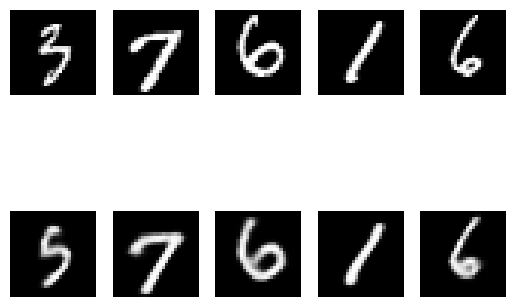

In [101]:
# reconstructing training images
train_imgs = next(iter(mnist_train_loader))[0]
display_ae_images(ae_model, train_imgs)

What about images from the test set?

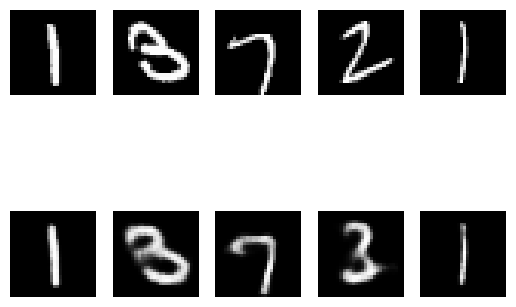

In [102]:
# reconstructing test images
test_imgs = next(iter(mnist_test_loader))[0]
display_ae_images(ae_model, test_imgs)

There is not too much overfitting at work here apparently. We can quantify this by computing the reconstruction loss over the test dataset (below) and comparing it to the reconstruction loss over the training dataset at the end of training (check the training cell above).

In [103]:
ae_model.eval()
test_loss=0.0

# We will store all the latent codes corresponding to the test images for reuse
# later on.
zs_test = np.zeros((len(mnist_test_loader.dataset),ae_model.latent_dim))

n = 0
with tqdm(mnist_test_loader, unit="batch") as tepoch:
  for data, labels in tepoch:
    # Put the data on the correct device:
    data = data.to(device)

    # Pass the data through the model
    predict = ae_model(data)
    reconstructions = predict['reconstructions']
    z = predict['codes']

    # Compute the AE loss
    loss = reconstruction_loss(reconstructions, data)

    # Store quantities of interest
    minibatch_size = z.shape[0]
    zs_test[n:(n+minibatch_size),:] = z.detach().cpu().numpy()

    # Compute the loss
    test_loss += loss.item()

    # tqdm bar displays the loss
    tepoch.set_postfix(loss=loss.item())

    # increment n to fill next parts of the arrays
    n += minibatch_size

print('Test Loss: {:.4f}'.format(test_loss/len(mnist_test_loader)))

100%|██████████| 157/157 [00:05<00:00, 27.13batch/s, loss=82.2]

Test Loss: 85.7555


The test and training average reconstruction losses are indeed similar.

Are you happy with the quality of the __reconstructions__? Next, we will see if this autoencoder model is good at __generating__ images.

**Answer:**

The autoencoder shows strong performance in generalization, evidenced by consistent reconstruction losses across training and test data, indicating no significant overfitting. For qualitative evaluation, visual inspection of reconstructions is crucial to confirm if the model accurately captures important image features.

Regarding image generation, traditional autoencoders like yours are limited compared to specialized models such as Variational Autoencoders (VAEs) or Generative Adversarial Networks (GANs), which are better suited for generating new images. Exploring latent space interpolations can provide insights into how the model transitions between learned features, but for generating new images, consider transitioning to a model designed for generative tasks.

# 2. Image generation with the vanilla autoencoder

Unfortunately, the vanilla autoencoder is not in itself a generative model because it does not define a joint probability distribution of the data and latent codes. We need to come up with roundabout ways to synthetize data based on this model.

In this section, we consider two naïve approaches to creating generative models from the AE. The general idea is the following:

- train an autoencoder
- estimate different statistics (mean, variance) of the data in the latent space
- using these statistics, define a model based on a Gaussian distribution in the latent space
- generate latent codes with this distribution, then decode them back to image space to obtain synthetic images

We will consider these two situations :

- a multivariate Gaussian distribution with __diagonal covariance matrix__ (each latent variable is an independent random variable). This requires the mean and variance in each latent variable;
- a multivariate Gaussian distribution with __non-diagonal covariance matrix__. This requires the mean and covariance matrix of the latent codes.

Obviously, since this is done _a posteriori_ after training the autoencoder, there is nothing which guarantees that the latent codes do indeed follow a Gaussian distribution. Our goal will be to verify that Variational Autoencoders indeed produce better results than such naïve approaches.

### 2.0. Defining and generating random Gaussian latent codes

Let $z$ be a latent code and $D$ the dimension of the latent space (called ``latent_dim`` in the code). We suppose that the $z$'s follow a multivariate Gaussian distribution, written as:

\begin{equation}
z \sim \mathcal{N}\left(
\mu,
\bf{C}
\right),
\end{equation}
where $\mu$ and $\bf{C}$ are the mean vector and covariance matrix of the Gaussian distribution. To define such a generative model, we must therefore determine $\mu$ and $\bf{C}$. Once this is done, we can generate a random Gaussian latent code in the following manner:

\begin{equation}
z = \mu + {\bf{L}} \varepsilon,
\end{equation}
where $\varepsilon$ is a random vector drawn from a multivariate normal distribution ($\mu=0$ and ${\bf{C}} = \text{Id}$), and $\bf{L}$ is output by a Cholesky decomposition of the positive semi-definite covariance matrix. In other words:

\begin{equation}
{\bf{C}} = {\bf{L}}{\bf{L}^T}.
\end{equation}

This gives a simple method of producing a multivariate Gaussian random variable.

### 2.1. A Gaussian model with diagonal covariance

The first naïve model is  defined in this first case as:

- $\bf{\mu}=\left[\mu_0, \mu_1, \cdots, \mu_{d-1}\right]^T$
- $
  \bf{C} = \begin{pmatrix}
\sigma_0^2 & 0 & \cdots & 0 \\
0 & \sigma_1^2 & \cdots & 0 \\
\vdots & \ddots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_{d-1}^2
\end{pmatrix}$

In this situation, therefore, the matrix $\bf{L}$ can be calculated quite simply, as:
- $
  \bf{L} = \begin{pmatrix}
\sigma_0 & 0 & \cdots & 0 \\
0 & \sigma_1 & \cdots & 0 \\
\vdots & \ddots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_{d-1}
\end{pmatrix}$

We are going to compute the mean and the component-wise standard deviations from a batch of data. For simplicity you are going to use the latent codes `zs_test` corresponding to the test data to estimate these quantities.<br>

It is actually bad practice, and it would be better to estimate them from the training dataset. We do not do so here for convenience because we have already computed `zs_test` above (we have verified above that overfitting was not a problem, so the difference between the two estimates should be minor).

In [104]:
# zs_test is of shape (N,D) where N is the test dataset size and D the latent dimension
# Compute the vector of mean values and the vector of component-wise std's.
z_average = np.mean(zs_test, axis=0)
z_sigma = np.std(zs_test, axis=0)

print("Average of latent codes:",z_average)
print("Standard deviation of latent codes:",z_sigma)

Average of latent codes: [-8.85468533 15.17751306 17.01929926 11.58433965 -3.13572592  6.38032318
 -8.10075021 -0.12056771  4.12286407  6.8625337 ]
Standard deviation of latent codes: [5.88665917 5.26157446 5.59998321 5.54143984 6.40677863 5.728305
 6.27025392 6.03492374 4.92420857 5.50876205]


Now, in the next cell generate data with this simple generative model using the approach described above. Display these images with the `display_images` function.

__Hint__. You do not actually have to define the matrix $\bf{L}$ in this case, an element-wise multiplication of two (properly chosen) vectors will suffice. To generate multivariate normal random variables you can use the following Pytorch function:

- `torch.randn`

To convert a numpy array to pytorch tensor, use `torch.from_numpy(...).float()`


In [105]:
def generate_images_diagonal_gaussian(ae_model, z_average, z_sigma, n_images = 5):
    # Sample noise from a standard Gaussian distribution
    epsilon = torch.randn(n_images, len(z_average))

    # Convert mean and std dev from numpy arrays to torch tensors
    z_average = torch.from_numpy(z_average).float().to(device)
    z_sigma = torch.from_numpy(z_sigma).float().to(device)

    # Using epsilon, generate samples from N(mu,C)
    z_generated = z_average + z_sigma * epsilon

    # Decode back to image space
    imgs_generated = ae_model.decoder(z_generated.to(device))

    return imgs_generated

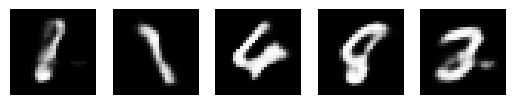

In [106]:
imgs_generated = generate_images_diagonal_gaussian(ae_model, z_average, z_sigma, n_images=5)
display_images(imgs_generated)

What do you think of these samples? Next let's try a slightly more sophisticated model.

**Answer:**

The main issues with the generated images using the simple Gaussian model with diagonal covariance in the vanilla autoencoder were poor visual quality and a lack of diversity among the images. The visual quality issue relates to the images not being crisp or detailed enough, often appearing blurry or distorted, which makes them not easily recognizable as MNIST digits. The lack of diversity means the generated images look too similar to each other, indicating that the model's latent space may not be capturing the full complexity and variability of the dataset. These issues suggest that the model's current approach to sampling and reconstructing images from the latent space is too simplistic and fails to adequately model the underlying data distribution.

### 2.2. Non-diagonal Gaussian model

The second model uses a non-diagonal covariance matrix $\bf{C}$ in the multivariate Gaussian distribution. In the next cell, calculate the mean and covariance matrix from `zs_test`.

__Hint__. You can use the `np.cov` function. Make sure to put the data in the right format for this. Print the shape of z_covariance to verify that you have a matrix of the correct shape (the covariance matrix and not the Gram matrix).

In [107]:
z_average = np.mean(zs_test, axis=0)
z_covariance = np.cov(zs_test, rowvar=False)

print("Average of latent codes:", z_average)
print("Covariance matrix of latent codes:", z_covariance)

Average of latent codes: [-8.85468533 15.17751306 17.01929926 11.58433965 -3.13572592  6.38032318
 -8.10075021 -0.12056771  4.12286407  6.8625337 ]
Covariance matrix of latent codes: [[ 34.65622185  -2.3458894    4.97472187   4.96496511 -13.70362242
  -13.89412914   0.87368037   4.33836289   9.65479222  -5.96452637]
 [ -2.3458894   27.68693447   4.0521347    3.19249659   2.65650213
    1.97665947   8.04953757   7.60374308   2.83279537  -4.30234782]
 [  4.97472187   4.0521347   31.36294827   0.0507858   -4.9441055
    0.15652958  -8.87755231  -4.52451079   4.73846331  -4.41356582]
 [  4.96496511   3.19249659   0.0507858   30.71062659  -9.94824638
   -0.22789847  -8.29080525   3.94942053  -4.55463986  -5.02000363]
 [-13.70362242   2.65650213  -4.9441055   -9.94824638  41.05091747
   -5.81350489   8.42850968 -15.81509577  -7.94425797  11.61443449]
 [-13.89412914   1.97665947   0.15652958  -0.22789847  -5.81350489
   32.81675985  -9.21972314  15.88606972   3.88591165  -7.22017182]
 [  0.87

Now, generate some samples with this distribution. In this case, you actually have to calculate the Cholesky decomposition and find $\bf{L}$. For this, you can use `np.linalg.cholesky`. Then compute the latent codes according to $z = \mu + {\bf{L}} \varepsilon$.

__Hint__. You can use `torch.matmul`. Pay attention to the dimension of `epsilon` to implement it correctly.

In [108]:
# calculate Cholesky decomposition of covariance matrix : C = L L^T
L = np.linalg.cholesky(z_covariance)

In [109]:
def generate_images_non_diagonal_gaussian(ae_model, z_average, L, n_images=5):
    # Generate noise according to a standard Gaussian distribution
    epsilon = torch.randn(n_images, L.shape[0]).to(device)

    # Convert the average and Cholesky decomposition to PyTorch tensors
    z_average = torch.from_numpy(z_average).float().to(device)
    L = torch.from_numpy(L).float().to(device)

    # Sample latent codes using epsilon
    # The matrix multiplication transforms epsilon into the distribution defined by the mean and covariance
    z_generated = z_average + torch.matmul(epsilon, L.t())

    # Decode back to image space
    imgs_generated = ae_model.decoder(z_generated.to(device))

    return imgs_generated


Generate images using this model now:

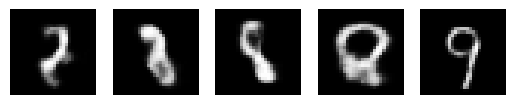

In [110]:
imgs_generated = generate_images_non_diagonal_gaussian(ae_model, z_average, L, n_images = 5)
display_images(imgs_generated)

You should see some improvement, but we can do better than this. Thus, we turn to the variational autoencoder.

# 3. Variational autoencoder

Now, we are going to create a variational autoencoder to carry out __image generation__. Let's first recall the idea of a variational autoencoder.

### Main idea

The main idea is to create an autoencoder whose latent codes follow a certain distribution (a Gaussian distribution in practice). This is done with two tools :

- A specific architecture, where the encoder produces the mean and variance of the latent codes
- A specially designed loss function

Once the VAE is trained, it is possible to sample in the latent space by producing random normal variables and simply decoding.

### Architecture

The architecture of the VAE model is the same as before (using `Encoder` with `multiplier=2` and `Decoder`). However the wrapper `VAEModel` will be a bit more complex as we need to implement the reparametrization trick. We will also implement the code to generate samples (for test time).

### Variational Autoencoder loss

The VAE loss consists in a reconstruction loss and a KL divergence term.

- The reconstruction loss is the same `reconstruction_loss` as before. In other words, the reconstructions are compared to the input images using binary cross-entropy. The reconstructions are generated by sampling a latent code from $q(z|x)$ and decoding it back to image space.

- You will implement the KL divergence term manually below.

In [111]:
class VAEModel(nn.Module):
    def __init__(self, latent_dim):
        super(VAEModel, self).__init__()

        self.latent_dim = latent_dim
        # Encoder and Decoder Initialization
        self.encoder = Encoder(latent_dim=latent_dim, multiplier=2)  # 'multiplier=2' for mean and log-var
        self.decoder = Decoder(latent_dim=latent_dim)

    def reparameterize(self, mean, logvar, mode='sample'):
        """
        Samples from a normal distribution using the reparameterization trick.

        Parameters
        ----------
        mean : torch.Tensor
            Mean of the normal distribution. Shape (batch_size, latent_dim)

        logvar : torch.Tensor
            Diagonal log variance of the normal distribution. Shape (batch_size,
            latent_dim)

        mode : 'sample' or 'mean'
            Returns either a sample from qzx, or just the mean of qzx. The former
            is useful at training time. The latter is useful at inference time as
            the mean is usually used for reconstruction, rather than a sample.
        """
        if mode=='sample':
            # Implements the reparametrization trick (slide 43):
            std = torch.exp(0.5 * logvar)  # Standard deviation
            eps = torch.randn_like(std)  # Random noise
            return mean + eps * std
        elif mode=='mean':
            return mean
        else:
            return ValueError("Unknown mode: {mode}".format(mode))

    def forward(self, x, mode='sample'):
        """
        Forward pass of model, used for training or reconstruction.

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)

        mode : 'sample' or 'mean'
            Reconstructs using either a sample from qzx or the mean of qzx
        """

        # stats_qzx is the output of the encoder
        stats_qzx = self.encoder(x)

        # Use the reparametrization trick to sample from q(z|x)
        samples_qzx = self.reparameterize(*stats_qzx.unbind(-1), mode=mode)

        # Decode the samples to image space
        reconstructions = self.decoder(samples_qzx)

        # Return everything:
        return {
            'reconstructions': reconstructions,
            'stats_qzx': stats_qzx,
            'samples_qzx': samples_qzx}

    def sample_qzx(self, x):
        """
        Returns a sample z from the latent distribution q(z|x).

        Parameters
        ----------
        x : torch.Tensor
            Batch of data. Shape (batch_size, n_chan, height, width)
        """
        stats_qzx = self.encoder(x)
        mean, logvar = stats_qzx[:, :self.latent_dim], stats_qzx[:, self.latent_dim:]
        samples_qzx = self.reparameterize(mean, logvar)
        return samples_qzx

    def sample_pz(self, N):
        samples_pz = torch.randn(N, self.latent_dim, device=self.encoder.conv1.weight.device)
        return samples_pz

    def generate_samples(self, samples_pz=None, N=None):
        if samples_pz is None:
            if N is None:
                return ValueError("samples_pz and N cannot be set to None at the same time. Specify one of the two.")

            # If samples z are not provided, we sample N samples from the prior
            # p(z)=N(0,Id), using sample_pz
            samples_pz = self.sample_pz(N) # FILL IN CODE

        # Decode the z's to obtain samples in image space (here, probability
        # maps which can later be sampled from or thresholded)
        generations = self.decoder(samples_pz) # FILL IN CODE
        return {'generations': generations}

The KL divergence term is computed as per the regularization term in slide 45 i.e., for each data sample in the mini-batch:
$$\frac{1}{2}\sum_{j=1}^D (\mu_j^2 + \sigma_j^2 - 1 - \log{\sigma_j^2})$$

In [112]:
def kl_normal_loss(mean, logvar):
    """
    Calculates the KL divergence between a normal distribution
    with diagonal covariance and a unit normal distribution.

    Parameters
    ----------
    mean : torch.Tensor
        Mean of the normal distribution. Shape (batch_size, latent_dim) where
        D is dimension of distribution.

    logvar : torch.Tensor
        Diagonal log variance of the normal distribution. Shape (batch_size,
        latent_dim)
    """
    # To be consistent with the reconstruction loss, wetake the mean over the
    # minibatch (i.e., compute for each sample in the minibatch according to
    # the equation above, then take the mean).
    # Calculate each term of the KL divergence formula
    term1 = mean.pow(2)
    term2 = logvar.exp()
    term3 = 1
    term4 = logvar

    # Sum terms up and average over all dimensions and then take the mean over the batch
    latent_kl = 0.5 * torch.sum(term1 + term2 - term3 - term4, dim=1).mean()

    return latent_kl

The `BetaVAELoss` puts it all together as per slide 55.

In [114]:
class BetaVAELoss(object):
    """
    Compute the Beta-VAE loss

    Parameters
    ----------
        beta: (scalar) the weight assigned to the regularization term
    """

    def __init__(self, beta):
        self.beta = beta

    def __call__(self, reconstructions, data, stats_qzx):
        mean, logvar = stats_qzx.unbind(-1)

        # Reconstruction loss
        rec_loss = reconstruction_loss(reconstructions, data)

        # KL divergence loss
        kl_loss = kl_normal_loss(mean, logvar)

        # Total loss of beta-VAE
        loss = rec_loss + self.beta * kl_loss

        return loss

### Training the Variational Autoencoder

This follows the traditional pipeline that you are by now familiar with.

In [115]:
latent_dim = 10

learning_rate = 1e-3
n_epoch = 5 # use the same number of epochs as before for fairness

In [116]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [118]:
vae_model = VAEModel(latent_dim=latent_dim)
vae_model = vae_model.to(device)

In [119]:
# To keep it simple, we can leave beta at 1.0 for the beta-VAE loss
# Feel free to experiment with it to see different trade-offs between reconstruction
# and generation performance.

beta = 1.0
vae_loss = BetaVAELoss(beta=beta)

In [120]:
# AdamW, with learning rate set to the parameter above and weight decay to 1e-4
optimizer = optim.AdamW(vae_model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [121]:
vae_model.train()

for epoch in range(0,n_epoch):
  train_loss=0.0

  with tqdm(mnist_train_loader, unit="batch") as tepoch:
    for data, labels in tepoch:
        tepoch.set_description(f"Epoch {epoch}")

        # Move data to the appropriate device
        data = data.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Pass the input data through the VAE model
        predict = vae_model(data)
        reconstructions = predict['reconstructions']
        stats_qzx = predict['stats_qzx']

        # Compute the beta-VAE loss
        loss = vae_loss(reconstructions, data, stats_qzx)

        # Backpropagate the loss
        loss.backward()
        optimizer.step()

        # Aggregate the training loss for display at the end of the epoch
        train_loss += loss.item()

        # Update the tqdm bar to show the current loss
        tepoch.set_postfix(loss=loss.item())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(mnist_train_loader)))

Epoch 0: 100%|██████████| 938/938 [00:58<00:00, 15.93batch/s, loss=139]


Epoch 0: Train Loss: 175.2940


Epoch 1: 100%|██████████| 938/938 [00:58<00:00, 15.95batch/s, loss=112]


Epoch 1: Train Loss: 125.6520


Epoch 2: 100%|██████████| 938/938 [00:59<00:00, 15.81batch/s, loss=125]


Epoch 2: Train Loss: 117.8193


Epoch 3: 100%|██████████| 938/938 [00:58<00:00, 15.93batch/s, loss=115]


Epoch 3: Train Loss: 114.0299


Epoch 4: 100%|██████████| 938/938 [00:59<00:00, 15.86batch/s, loss=113]

Epoch 4: Train Loss: 111.7044


### Testing the VAE model

Let's check how well the VAE reconstructs training samples:

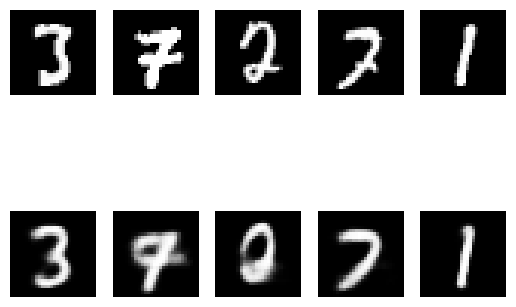

In [122]:
# reconstructing training images
train_imgs = next(iter(mnist_train_loader))[0]
display_ae_images(vae_model, train_imgs)

Same for test samples:

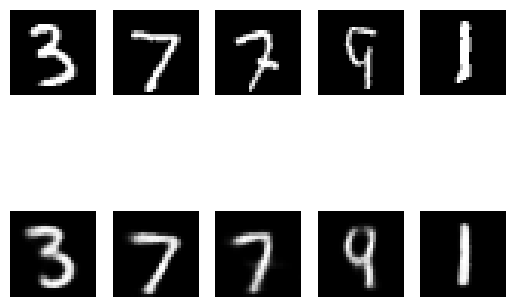

In [123]:
# reconstructing test images
test_imgs = next(iter(mnist_test_loader))[0]
display_ae_images(vae_model, test_imgs)

Let's compute the quantitative `reconstruction_loss` on the test data:

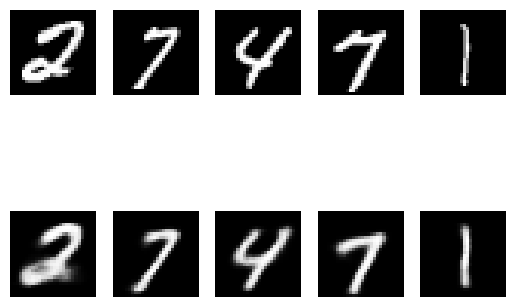

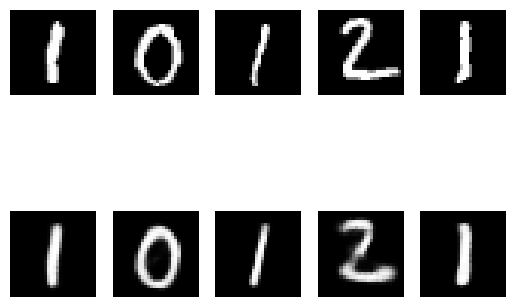

Computing test loss: 100%|██████████| 157/157 [00:04<00:00, 37.38batch/s]

Average Reconstruction Loss on Test Data: 93.0015


In [124]:
# !!! If you copy paste code, don't forget to change ae_model to vae_model !!!

# FILL IN CODE

# Visual evaluation: Reconstruct training images
train_imgs = next(iter(mnist_train_loader))[0]
display_ae_images(vae_model, train_imgs)

# Visual evaluation: Reconstruct test images
test_imgs = next(iter(mnist_test_loader))[0]
display_ae_images(vae_model, test_imgs)

# Quantitative evaluation: Compute reconstruction loss on the test data
vae_model.eval()  # Set the model to evaluation mode

test_loss = 0.0
n_samples = 0

with torch.no_grad():  # Inference only, no gradients needed
    for data, _ in tqdm(mnist_test_loader, desc="Computing test loss", unit="batch"):
        data = data.to(device)
        output = vae_model(data)
        reconstructions = output['reconstructions']

        loss = reconstruction_loss(reconstructions, data)
        test_loss += loss.item() * data.size(0)
        n_samples += data.size(0)

average_test_loss = test_loss / n_samples
print(f"Average Reconstruction Loss on Test Data: {average_test_loss:.4f}")


### Image generation with the VAE model

Now, generate some images with the VAE model. You can directly use the `generate_samples` routine from the `VAEModel` class above.

In [125]:
def generate_images_vae(vae_model, n_images=5):
    # Use the generate_samples method from VAEModel to sample and decode images
    generated_data = vae_model.generate_samples(N=n_images)

    # The generated images are stored under the key 'generations'
    generated_images = generated_data['generations']

    return generated_images

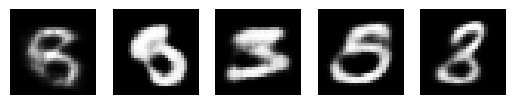

In [126]:
imgs_generated = generate_images_vae(vae_model)

display_images(imgs_generated)

Do you think the results are better ? What advantage does the Variational Autoencoder have over the simple autoencoder model, even though the second (non-diagonal Gaussian model) AE approach has a more complex probabilistic latent model (a full covariance matrix)?

**Answer:**

The Variational Autoencoder (VAE) generally offers superior performance and capabilities over a simple Autoencoder (AE), particularly for tasks involving the generation of new data. The VAE models the latent space as a probabilistic distribution, inherently supporting the generation of diverse and realistic images by sampling from this distribution. This is fundamentally integrated into the training process through the minimization of both reconstruction loss and KL divergence, ensuring that the latent space is informative for reconstruction while adhering to a controlled distribution.

In contrast, while an AE with a non-diagonal Gaussian model attempts to enhance generation capabilities by estimating complex latent distributions post hoc, it lacks the VAE's integrated approach and theoretical backing. This often results in a latent space that is optimal for reconstruction but less effective for generation. The VAE's structured approach, including mechanisms to balance reconstruction fidelity with latent space regularization (such as the β parameter in Beta-VAEs), provides greater flexibility and control, making it better suited for generating new, high-quality samples.

Next, we compare the models quantitavely.

# 4. Evaluating and comparing the models for image generation

In [127]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Nowadays, the standard metric to evaluate the generative performance of a model is the FID (Fréchet Inception Distance). I leave it for you as optional homework to implement it if you wish to do so.

Here, we will follow another path, a simplified version of the Inception Score (IS) that has been somewhat superseded by the FID:

- we train a simple convolutional neural network classifier on MNIST, to a good accuracy
- we generate images with each model
- we find the average of the highest probability of the images according to the classifier, for each model. If this value is high, it means that on average the classifier considers that the images looks like a real image of an actual digit

We will use the following simple convolutional architecture for the classifier:

- conv2d, 3x3 kernel, 32 filters, stride=2, padding=1; + ReLU + BatchNorm2d
- conv2d, 3x3 kernel, 64 filters, stride=2, padding=1; + ReLU + BatchNorm2d
- conv2d, 3x3 kernel, 128 filters, stride=2, padding=1; + ReLU + BatchNorm2d
- Global Average Pooling
- Flatten
- Dense layer

Now, define the model. To make things easier, we use the `torch.nn.Sequential` API to implement the model (there is no need for a Class in this simple case).

__Hint__. For the global average pooling, use the `torch.nn.AvgPool2d` layer with the suitable kernel size and stride.

In [128]:
nb_classes = 10
kernel_size = (3, 3)
stride = 2
padding = 1

mnist_classification_model = torch.nn.Sequential(
    # First convolutional layer
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=kernel_size, stride=stride, padding=padding),
    nn.ReLU(),
    nn.BatchNorm2d(32),

    # Second convolutional layer
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, stride=stride, padding=padding),
    nn.ReLU(),
    nn.BatchNorm2d(64),

    # Third convolutional layer
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_size, stride=stride, padding=padding),
    nn.ReLU(),
    nn.BatchNorm2d(128),

    # Global Average Pooling
    nn.AdaptiveAvgPool2d(1),

    # Flatten the output for the dense layer
    nn.Flatten(),

    # Dense layer to classify the images into 10 classes (for the 10 digits)
    nn.Linear(128, nb_classes)
)

# Move the model to the appropriate device (GPU or CPU)
mnist_classification_model = mnist_classification_model.to(device)


In [129]:
learning_rate = 1e-2
n_epoch = 5

In [130]:
# Cross entropy with reduction='sum'
criterion = nn.CrossEntropyLoss(reduction='sum')

In [131]:
# AdamW, weight decay set to 1e-4
optimizer = optim.AdamW(mnist_classification_model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [132]:
def vector_to_class(x):
  y = torch.argmax(F.softmax(x,dim=1),axis=1)
  return y

In [133]:
def cnn_accuracy(x_pred,x_label):
  acc = (x_pred == x_label).sum()/(x_pred.shape[0])
  return acc

In [134]:
mnist_classification_model.train()

for epoch in range(0, n_epoch):
    train_loss = 0.0
    all_labels = []
    all_predicted = []

    with tqdm(mnist_train_loader, unit="batch") as tepoch:
        for imgs, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            # Put data on the correct device
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Zero the gradients before running the forward pass
            optimizer.zero_grad()

            # Forward pass to get the output logits
            predict = mnist_classification_model(imgs)

            # Compute the loss
            loss = criterion(predict, labels)

            # Backpropagation to compute gradients
            loss.backward()

            # Update the model weights
            optimizer.step()

            # Compute the train loss (sum of losses over the batch)
            train_loss += loss.item()

            # Store labels and class predictions for accuracy computation
            all_labels.extend(labels.cpu().tolist())
            all_predicted.extend(vector_to_class(predict).cpu().tolist())

            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    # Calculate overall accuracy
    accuracy = cnn_accuracy(torch.tensor(all_predicted), torch.tensor(all_labels))
    print(f'Epoch:{epoch} Train Loss:{train_loss / len(mnist_train_loader.dataset):.4f} Accuracy:{accuracy:.4f}')


Epoch 0: 100%|██████████| 938/938 [00:53<00:00, 17.61batch/s, loss=1.92]


Epoch:0 Train Loss:0.1661 Accuracy:0.9488


Epoch 1: 100%|██████████| 938/938 [00:55<00:00, 16.81batch/s, loss=0.261]


Epoch:1 Train Loss:0.0615 Accuracy:0.9805


Epoch 2: 100%|██████████| 938/938 [00:52<00:00, 17.80batch/s, loss=2.2]


Epoch:2 Train Loss:0.0475 Accuracy:0.9852


Epoch 3: 100%|██████████| 938/938 [00:55<00:00, 16.84batch/s, loss=0.0427]


Epoch:3 Train Loss:0.0383 Accuracy:0.9872


Epoch 4: 100%|██████████| 938/938 [00:52<00:00, 17.89batch/s, loss=0.0851]


Epoch:4 Train Loss:0.0312 Accuracy:0.9897


In [135]:
mnist_classification_model.eval()

all_predicted = []
all_labels = []

with tqdm(mnist_test_loader, unit="batch") as tepoch:
  for imgs, labels in tepoch:
    all_labels.extend(labels.tolist())

    imgs = imgs.to(device)
    predict=mnist_classification_model(imgs)
    all_predicted.extend(vector_to_class(predict).tolist())

test_accuracy = cnn_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)

100%|██████████| 157/157 [00:03<00:00, 50.87batch/s]



Test Accuracy: 0.9836


### Evaluate the average maximum prediction of the images generated by each generative model (higher is better)

Now, we evaluate the models. For each ones, produce a certain number of images, and put those images through the classification network. Then find the maximum class probability of each image, and average it over all the images. We will use this as a metric to evaluate each model.

__CAREFUL__: the output of the network does __not__ include the Softmax layer, so you will have to carry it out, with:
- ```torch.nn.Softmax()(...)```

Define this metric now:

In [136]:
def generative_model_score(imgs_in, classification_model):
    # Move images to the appropriate device
    imgs_in = imgs_in.to(device)

    # Get the predictions from the classification model
    predictions = classification_model(imgs_in)

    # Apply softmax to convert logits to probabilities
    probabilities = F.softmax(predictions, dim=1)

    # Get the maximum probability for each image
    max_probs = probabilities.max(dim=1)[0]

    # Calculate the average of these maximum probabilities
    gen_score = max_probs.mean().item()
    return gen_score

Now, generate some images with each of the three models, and evaluate these models:

In [137]:
imgs_diagonal_gaussian = generate_images_diagonal_gaussian(ae_model,z_average,z_sigma,n_images = 2000)
imgs_non_diagonal_gaussian = generate_images_non_diagonal_gaussian(ae_model,z_average,L,n_images = 2000)
imgs_vae = generate_images_vae(vae_model,n_images=2000)

# average of maximum of first model
diagonal_gaussian_score = float(generative_model_score(imgs_diagonal_gaussian,mnist_classification_model))
non_diagonal_gaussian_score = float(generative_model_score(imgs_non_diagonal_gaussian,mnist_classification_model))
vae_gaussian_score = float(generative_model_score(imgs_vae,mnist_classification_model))

print("Diagonal gaussian generative model score : ",diagonal_gaussian_score)
print("Non diagonal gaussian generative model score : ",non_diagonal_gaussian_score)
print("Variational autoencoder model score: ",vae_gaussian_score)

Diagonal gaussian generative model score :  0.8688862323760986
Non diagonal gaussian generative model score :  0.8999066948890686
Variational autoencoder model score:  0.8990873098373413


Questions:

- Which model is better quantitatively ? (unfortunately there is some variability, even with 2000 samples; you might want to rerun the cell several times to get the trend)
- Do the quantitative result support the qualitative results ?
- Can you see any drawbacks of this method of evaluation ?
- Can you propose any more sophisticated models than the multivariate Gaussian approach (apart from the variational autoencoder) ?

**Answer:**

1. **Which model is better quantitatively?**
   - Quantitatively, the model with the non-diagonal Gaussian generative model has a slightly higher score (0.8999) compared to the Variational Autoencoder (0.8991) and the diagonal Gaussian model (0.8689). This suggests that, for this particular run, the non-diagonal Gaussian model performed the best. However, the difference between the non-diagonal Gaussian model and the VAE is quite small, indicating similar performance. Multiple runs are necessary to discern a clear trend due to inherent variability.

2. **Do the quantitative results support the qualitative results?**
   - If the qualitative results (visual inspection of generated images) show that images from the non-diagonal Gaussian model and the VAE look more realistic and diverse compared to those from the diagonal Gaussian model, then the quantitative results do support the qualitative ones. Otherwise, if the visual quality does not match these scores, it may suggest limitations in how the evaluation metric aligns with human perception.

3. **Drawbacks of this method of evaluation:**
   - The primary drawback of using classifier-based metrics like these scores is their heavy reliance on the classifier's performance and biases. If the classifier is not well-generalized, it may not accurately reflect the true quality of the images. Additionally, this method evaluates realism but not diversity or novelty, which are also important aspects of generative models.

4. **More sophisticated models:**
   - Beyond the multivariate Gaussian and VAE approaches, other sophisticated models include:
     - **Generative Adversarial Networks (GANs)**: Known for producing high-quality images by training two networks in opposition to each other.
     - **Normalizing Flows**: Provides exact log-likelihood computation and reversible transformations, suitable for detailed and diverse sample generation.
     - **Autoregressive Models** like PixelCNN, which generate images pixel by pixel, ensuring high levels of detail and coherence.
     - **Energy-Based Models (EBMs)**: Learn an energy landscape where lower energies are more probable, allowing generation of diverse samples by navigating this landscape.

Each of these models offers distinct advantages in handling complex distributions, providing diversity, and achieving realistic image generation, potentially surpassing simpler Gaussian-based methods in various aspects.